# Weight mixing

This is a new kind of method to "train" models super fast without having to retrain the entire model again.

This method, introduced with the development of this mod, requires an overfitted model of your own dataset (in our case, `GPT-Neo-125M` combined with the AWSW data we extracted in step 1) + the pretrained model (`GPT-Neo-125M`).

Weight mixing essentialy involves 3 different steps, and can easily be done on CPU in mere seconds, if you manage to get the pretrained weights in advance:

 1. Generate samples from the base model (the model that came pretrained).
 
 2. Add a small amount of gaussian noise to a variable `s`.
 
 3. Do a linear interpolation between the base model and the main model (our own model) using `s` as a mask.
 
 4. Repeat generating samples on this interpolated model
 
     - Are the samples equal? Repeat from step 2.
     - Is even 1 sample different? Quit and move to step 5 (adding more noise to `s`).
   
 5. Now we have the portion that we know we can adjust without the model giving considerably different results. This is what we call the cold zone.
 
     - Using this new mask, we will linear interpolate between the base model and the main model given a user-specified `amount` and `cold_zone_diffusion_steps`.
     
     - `cold_zone_diffusion_steps` will "spread" noise slightly outside the cold zone by blurring, only affecting places that aren't used yet (i.e all the parts that are 0, the rest remains unchanged). The higher the value, the bigger area it will affect.
     
     - `amount` regulates the amount it'll transition between the main and base model.
    
**Note!** `cold_zone_diffusion_steps` can be skipped when not calling calculate_cold_zones, in this case we just do a simple linear interpolation between the 2 models.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager
from model_mixing import ModelMixing
from model_utils import get_model
from config import Config
import matplotlib.pyplot as plt

In [2]:
saved_model_path = os.path.join("models", "awsw_main_overfitted")
mixed_model_path = os.path.join("models", "awsw_mixed")
os.makedirs(mixed_model_path, exist_ok=True)
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
main_model = AutoModelForCausalLM.from_pretrained(saved_model_path)
base_model, _ = get_model("EleutherAI/gpt-neo-125M")
target_model, _ = get_model("EleutherAI/gpt-neo-125M")
device = torch.device('cpu')
target_model.eval()
model_manager = ModelManager(model=target_model, tokenizer=tokenizer, device=device)
model_manager_main = ModelManager(model=main_model, tokenizer=tokenizer, device=device)
print(f"Loaded base and main model to CPU")

Loaded base and main model to CPU


# Initial test
This will mostly be gibberish. This is intentional, as the target model only contains the pre-trained GPT-Neo weights!target_model

In [3]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]    
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)

def rp_test(model_manager):
    for rp in test_rps:
        print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
        print("-" * 10)
    print("Lower case test")
    for rp in test_rps:
        rp = rp[0].lower() + rp[1:]
        print(f'{rp} -> {model_manager.say("", rp)}')
        rp = rp.lower()
        print(f'{rp} -> {model_manager.say("", rp)}')
        print("-" * 10)
        
prompt_test(model_manager_main, do_sample_test = False)

Prompt: How are you?
Reply: park2<msg>Ry "I'm not sure, exactly. It's probably some kind of vegetable blend."<p><msg>c "I see. What kind of meat is commonly eaten around here, anyway?"<d><scn>black<msg>Ry "Aurochs meat. Are you familiar with that animal?"<p><msg>c "I may have heard
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I think he's funny."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: black<msg>Ad "It's the practice of doing flying maneuvers like rolls, spins or loops."<p><msg>c "Just flying?"<d><scn>black<msg>Ad "Well, not {i}just{/i} flying."<d><scn>black<msg>Ad "I do Aerobatics, or stunt flying. I've been doing that on and
----------
Prompt: What will we do here?
Reply: facin2<msg>An "I'll just leave them here. No point in doing anything with them."<|endoftext|>
----------


In [4]:
def generate_cold_zone_loss_responses(model_manager):
    for (past, prompt) in prompts:
        yield model_manager.say(past, prompt)
    for rp in test_rps:
        yield model_manager.say("", rp)
        rp = rp[0].lower() + rp[1:]
        yield model_manager.say("", rp)
        rp = rp.lower()
        yield model_manager.say("", rp)

original_target_model_responses = list(generate_cold_zone_loss_responses(model_manager_main))
def cold_zone_loss() -> bool:
    new_responses = generate_cold_zone_loss_responses(model_manager)
    for r1, r2 in zip(original_target_model_responses, new_responses):
        if not r1 == r2:
            print(f"Not correct:\nOriginal: {r1}\nv.s\nNew: {r2}\n{'-' * 10}")
            return False
        return True

In [5]:
model_mixing = ModelMixing(tokenizer, base_model, main_model, target_model, seed = 45, cold_zone_loss = cold_zone_loss)

# Testing cold zone diffusion

Cold zone diffusion is mission-critical in determining where to mix models. It's gotta work well.

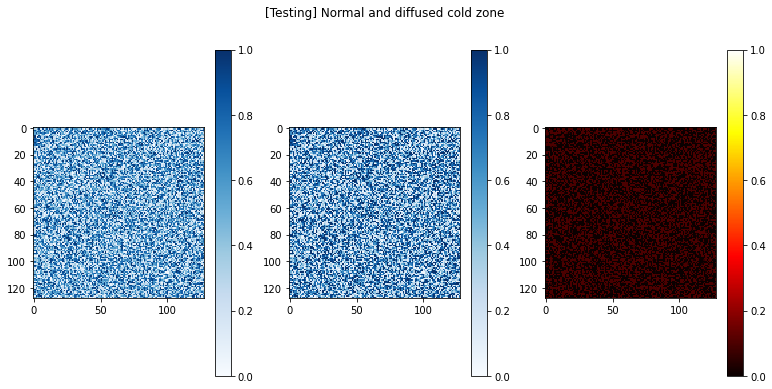

In [6]:
test_cold_zone = np.random.rand(128, 128)
test_cold_zone = torch.Tensor(test_cold_zone)
diffused_cold_zone = model_mixing.diffuse_cold_zone(test_cold_zone, upper_bound = 0.5, diffusion = 0.1)
fig, axs = plt.subplots(figsize=(13, 6), ncols=3)
fig.suptitle('[Testing] Normal and diffused cold zone')
pos = axs[0].imshow(test_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[0])
pos = axs[1].imshow(diffused_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[1])
pos = axs[2].imshow(abs(diffused_cold_zone - test_cold_zone), cmap='hot', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[2])
plt.show()

# Calculating the cold zones

Cold zones are the area of the main model that are *safe to adjust* i.e they won't change the answers of the model drastically. Later it's our task to use this cold zone and expand slowly until we get a desired results, coming from both models.

The process requires inference on both models, but no training. It's as slow as the models themselves, but is still feasible on CPU, and we only require samples, .

In [7]:
cold_zones_path = os.path.join(mixed_model_path, 'cold_zones.npz')
if os.path.exists(cold_zones_path):
    loaded_stuff = np.load(cold_zones_path)
    model_mixing.cold_zones = [
        torch.Tensor(loaded_stuff[key]) for key in loaded_stuff
    ]
    del loaded_stuff
else:
    model_mixing.calculate_cold_zones()
    to_save = []
    for i, c in enumerate(model_mixing.cold_zones):
        to_save.append(c.numpy())
    np.savez(cold_zones_path, *to_save)

Successful #1 cold-zone calculated (amp: 0.90 restart_tries: 0)
Successful #2 cold-zone calculated (amp: 0.89 restart_tries: 0)
Successful #3 cold-zone calculated (amp: 0.88 restart_tries: 0)
Successful #4 cold-zone calculated (amp: 0.87 restart_tries: 0)
Successful #5 cold-zone calculated (amp: 0.86 restart_tries: 0)
Successful #6 cold-zone calculated (amp: 0.85 restart_tries: 0)
Not correct:
Original: park2<msg>Ry "I'm not sure, exactly. It's probably some kind of vegetable blend."<p><msg>c "I see. What kind of meat is commonly eaten around here, anyway?"<d><scn>black<msg>Ry "Aurochs meat. Are you familiar with that animal?"<p><msg>c "I may have heard
v.s
New: park2<msg>Ry "I'm just a specimen, I'm not sure."<d><scn>park2<msg>Ry "Good to know."<d><scn>park2<msg>Ry "Well, what do you think of it?"<p><msg>c "It's pretty idyllic."<d><scn>park2<msg
----------
(restart_tries: 0 amp: 0.84)
Not correct:
Original: park2<msg>Ry "I'm not sure, exactly. It's probably some kind of vegetable blen

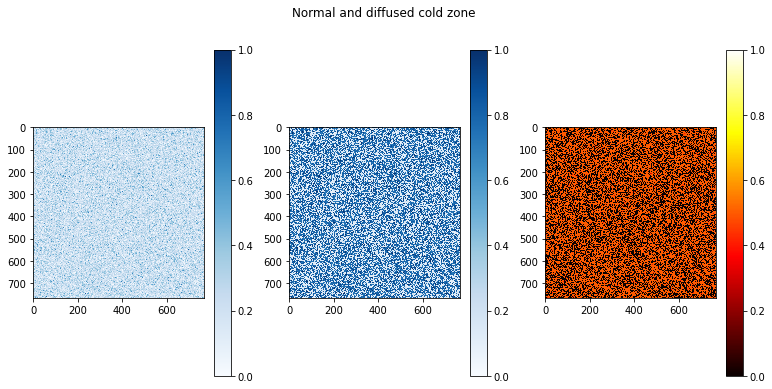

In [8]:
test_cold_zone = model_mixing.cold_zones[5]
diffused_cold_zone = model_mixing.diffuse_cold_zone(test_cold_zone, diffusion = 0.5, upper_bound = 0.2)
fig, axs = plt.subplots(figsize=(13, 6), ncols=3)
fig.suptitle('Normal and diffused cold zone')
pos = axs[0].imshow(test_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[0])
pos = axs[1].imshow(diffused_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[1])
pos = axs[2].imshow(abs(diffused_cold_zone - test_cold_zone), cmap='hot', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[2])
plt.show()

# Let the mixing begin!
The mixing process is the fastest of this whole notebok, and should take just a few seconds on a slow CPU.

In [23]:
model_mixing.mix(1, cold_zone_diffusion = 0.3, upper_bound = 0.1, normalize_cold_zone = False)

# Testing the mixed model

This model seems to perform as good and in most cases better than a finetuned model in our tests, let's see what it does now!

In [24]:
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry "I'm fine. I just have a few questions about the murder of your colleague."<d><scn>park2<msg>Ry "I'm afraid so."<d><scn>park2<msg>Ry "I'm afraid so, but I have to admit, I was kinda annoyed about the whole thing. I guess it showed."<
Reply [sampled]: park2<msg>Ry "I'm fine. I just have a few questions about the murder of your colleague."<d><scn>park2<msg>Ry "I'm afraid I've got some bad news for you."<p><msg>c "hey sebastian! over here!"<d><scn>park2<msg>Sb "Hey [
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I think he's funny."<|endoftext|>
Reply [sampled]: park2<msg>Ad "I think he's cute."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: o2<msg>Ad "It's a game. I'm not sure what it means."<p><msg>c "What do you think of Kevin?"<d><scn>o2<msg>Ad "I think he's cute."<|endoftext|>
Reply [sampled]: o2<msg>Ad "It's a long story."<p><msg>c "Oh, it's you."<d><scn>o2<msg>Ad "Hey, it's me."<p><msg>c "go to k

In [25]:
rp_test(model_manager)

Visit Lorem -> loremapt<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Meet with Lorem -> loremapt<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I wasn't expecting visitors."<|endoftext|>
----------
Fight Maverick -> o2<msg>Mv "I didn't want to talk to her, but I noticed she was not as friendly as you might think."<d><scn>o2<msg>Mv "You didn't know who I was going to find out, did you?"<p><msg>c "Meet with Reza"<d><scn>park1<msg>Rz "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Fight Adine -> cafe<msg>m "I barely avoids Adine's attack, but as I tried to flee, I saw Adine struggling. I tried to flee with my own free will, but as I left, one of my feet went below the surface, which caused me to spin. I threw my head up, but lost control."<d><scn>cafe<msg>m "I was about to ask Adine if I could stay, but she quic

In [26]:
target_model.save_pretrained(mixed_model_path)